In [ ]:
!pip install --force-reinstall pymc3

     |████████████████████████████████| 872 kB 13.4 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 62.3 MB/s 
     |████████████████████████████████| 1.8 MB 57.9 MB/s 
     |████████████████████████████████| 15.7 MB 36.2 MB/s 
     |████████████████████████████████| 233 kB 66.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 11.3 MB 54.5 MB/s 
     |████████████████████████████████| 40 kB 4.1 MB/s 
     |████████████████████████████████| 11.2 MB 67.2 MB/s 
     |████████████████████████████████| 4.6 MB 43.3 MB/s 
     |████████████████████████████████| 1.1 MB 57.5 MB/s 
     |████████████████████████████████| 845 kB 49.9 MB/s 
     |████████████████████████████████| 900 kB 65.7 MB/s 
     |████████████████████████████████| 247 kB 75.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
     |████████████████████████████████| 4.3 MB 55.1 MB/s 
     |█████████

In [1]:
!pip install blackjax

     |████████████████████████████████| 74 kB 2.2 MB/s 


In [15]:
"""Import the relevant libraries"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.random as random
import blackjax
import jax.numpy as jnp

Generate Artificial data

In [4]:
rng=np.random.RandomState(1)


In [5]:
rng

RandomState(MT19937) at 0x7FF09D36AAF0

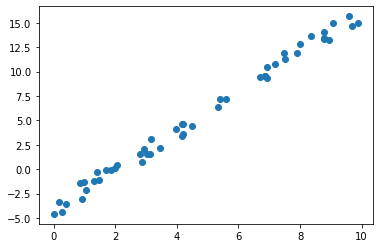

In [6]:
x = 10 * rng.rand(50)
y = 2 * x - 5 + 2*rng.rand(50)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

plt.scatter(x, y)

In the below few lines of code, I sampled using blackjax sampler(HMC)

In [7]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

In [8]:
def logprob_fn(loc, scale, observed=observed):
    """Univariate Normal"""
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


logprob = lambda x: logprob_fn(**x)

In [9]:
inv_mass_matrix = np.array([0.5, 0.5])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logprob, step_size, inv_mass_matrix, num_integration_steps)

PyMC3 module is created

In [10]:
import pymc3 as pm
print('Running on the PyMC3 v{}'.format(pm.__version__))
basic_model =  pm.Model()

Running on the PyMC3 v3.11.4


Model parameters i.e. alpha,beta and gamma are defined

In [11]:
with basic_model as bm:

    #Priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Deterministics
    mu = alpha + beta*x
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sd=sigma, observed=y)

Posterior sampling is done using pm model

In [12]:
trace = pm.sample(draws=2000,model=bm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """Entry point for launching an IPython kernel.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


PyMC3 automatically chooses appropriate model depending on the type of data. In my case of continuous data, NUTS is used.

In [13]:
trace

<MultiTrace: 2 chains, 2000 iterations, 4 variables>

In [16]:
step_size = 1
inverse_mass_matrix = jnp.array([1., 1.])

In [17]:
trace1=blackjax.nuts(bm,step_size,inverse_mass_matrix)

Here, I did nuts sampling using blackjax

In [ ]:
trace1

SamplingAlgorithm(init=<function nuts.__new__.<locals>.init_fn at 0x7efdac78fdd0>, step=<function nuts.__new__.<locals>.step_fn at 0x7efdac78f950>)

In [18]:
observed = np.random.normal(10, 20, size=1_000)
def logprob_fn(x):
  logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
  return jnp.sum(logpdf)

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logprob_fn, step_size, inverse_mass_matrix)

Here also I tried to find out nuts sampling using blackjax method. Here the method I followed is similar to nuts sampling by black jax

In [20]:
print(pm.summary(hmc).round(2))

ValueError: ignored

Here, I unsuccesfully tried to implement blackjax sampler

In [21]:
print(pm.summary(trace).round(2))

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -4.07  0.15   -4.36    -3.79        0.0      0.0    1998.0    2119.0   
beta   2.02  0.03    1.97     2.07        0.0      0.0    2066.0    2270.0   
sigma  0.59  0.06    0.48     0.70        0.0      0.0    1901.0    1657.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


This is the summary of the values that I got when I applied the nuts sampler(Pymc3) on the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff085568390>,
      dtype=object)

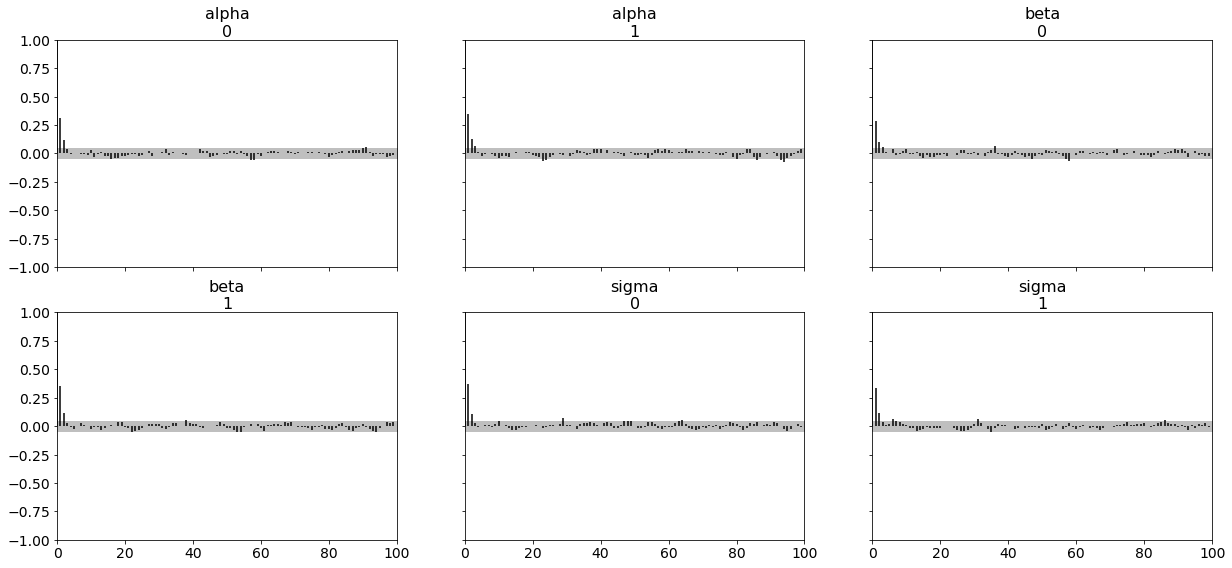

In [23]:
pm.autocorrplot(trace)

This is the autocorrelation plot of nuts sampler(pymc3)

No handles with labels found to put in legend.


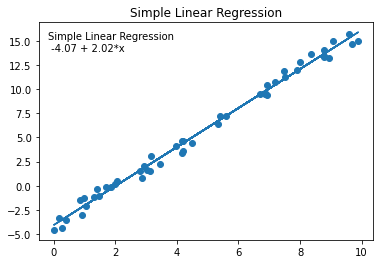

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
ypred =  lm.fit(x,y).predict(x)
plt.scatter(x,y)
plt.plot(x,ypred)
legend_title = 'Simple Linear Regression\n {} + {}*x'.format(round(lm.intercept_[0],2),round(lm.coef_[0][0],2))
legend = plt.legend(loc='upper left', frameon=False, title=legend_title)
plt.title("Simple Linear Regression")
plt.show()


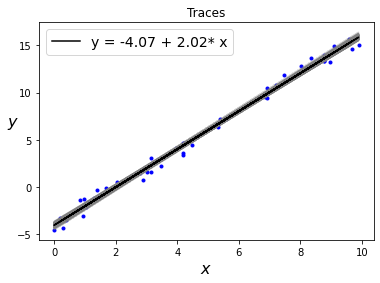

In [ ]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace['alpha']), 10)
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()

plt.plot(x, trace['alpha'][idx] + trace['beta'][idx] *x, c='gray', alpha=0.2);
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.title("Traces")
plt.show()


Here I tried to compare both simple linear regression and bayesian linear regression. As it is clearly observable, mean values of both alpha and beta are same

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08eff3d50>,
      dtype=object)

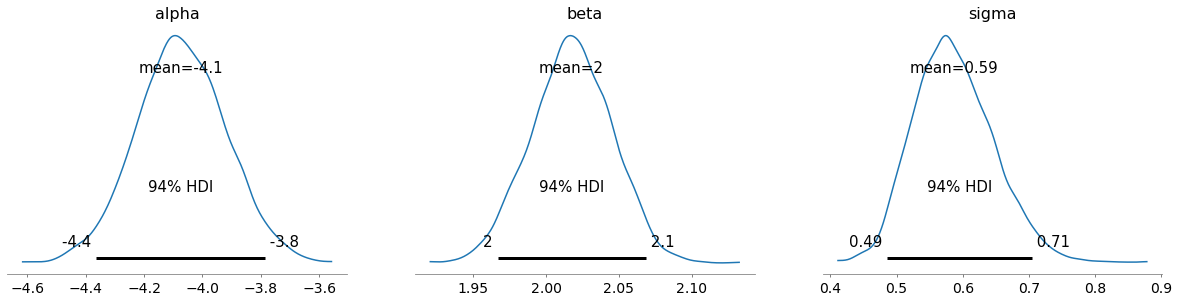

In [24]:
pm.plots.plot_posterior(trace)

These are the posterior density plot of all the parameters i.e. alpha, beta and gamma. All the graphs have 94% HDI(Highest Density Interval) which means credible interval has to remove 3% from each tail of distribution. Credible interval means the range containing a particular percentage of probable values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `densityplot` from PyMC3 is just an alias for `plot_density` from ArviZ. Please switch to `pymc3.plot_density` or `arviz.plot_density`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdaefe9150>,
      dtype=object)

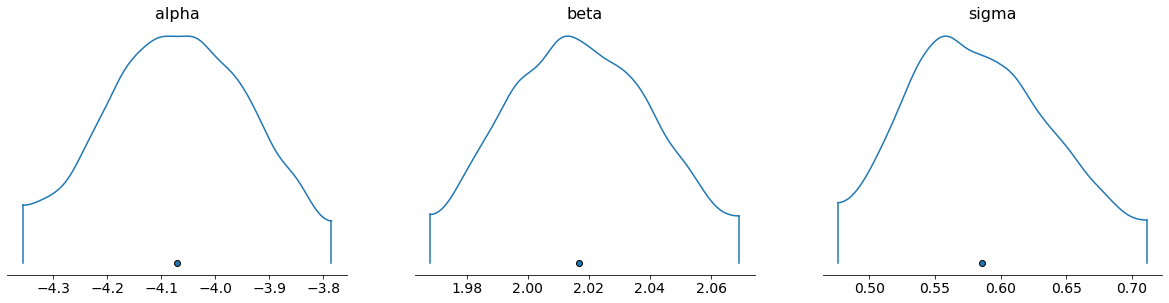

In [ ]:
pm.plots.densityplot(trace)

Generates KDE plots for continuous variables. Plots are truncated at their 100*(1-alpha)% credible intervals.

In [25]:
ypred = pm.sampling.sample_posterior_predictive(model=bm,trace=trace, samples=500)
y_sample_posterior_predictive = np.asarray(ypred['Ylikelihood'])

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Now I try to validate the model by using PPC(Posterior Predictive Checks)

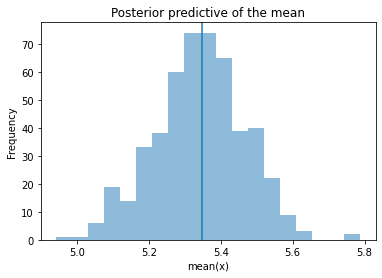

In [ ]:
_, ax = plt.subplots()
ax.hist([n.mean() for n in y_sample_posterior_predictive], bins=19, alpha=0.5)
ax.axvline(y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');